In [1]:

# To remove all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow import lite, cast, float32
from tensorflow import saved_model

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

2023-02-02 10:21:40.566247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:

# Resizing and moving function
def resize_img(SOURCE, DEST, SIZE=299):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  print(len(files))
  for filename in files:
    if '.jpg' in filename:
      img = cv2.imread(f"{SOURCE}{filename}")
      resize_img = cv2.resize(img, (SIZE,SIZE))
      cv2.imwrite(f"{SOURCE}/{filename}", resize_img)
      copy(f"{SOURCE}/{filename}",f"{DEST}/{filename}")



In [4]:
# Resizing the images 299 x 299
#resize_img(f'{os.getcwd()}/data/HAM10000_images_part_1/',f'{os.getcwd()}/data/resize_HAM10000/')
#resize_img(f'{os.getcwd()}/data/HAM10000_images_part_2/',f'{os.getcwd()}/data/resize_HAM10000/')

try:
    os.mkdir(f'{os.getcwd()}/data/images/resize_HAM10000') 
except:
    pass
HAM_resize_list = os.listdir('data/images/resize_HAM10000/')

In [5]:
path = 'data/'
skin_df = pd.read_csv(path + 'HAM10000_metadata.csv')
image_path = path + '/images/resize_HAM10000'

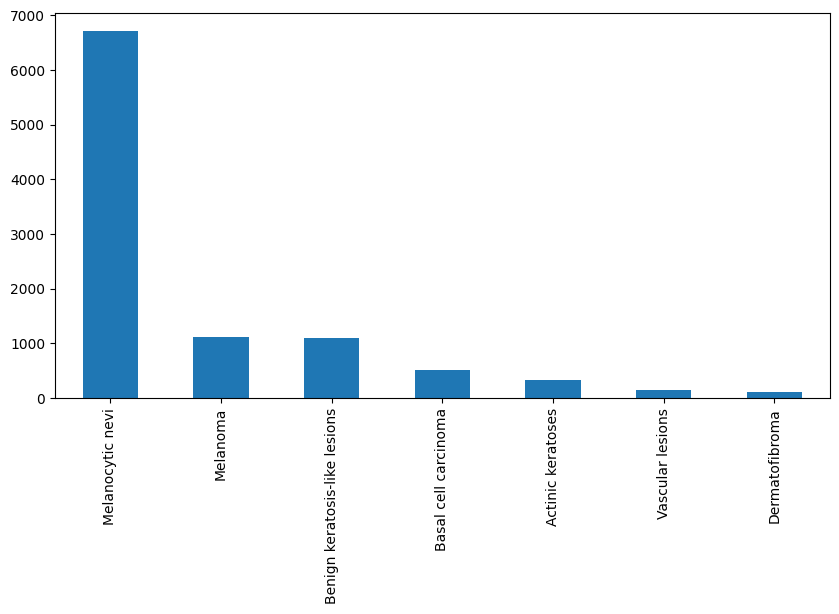

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Creating New Columns for better readability
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 

skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

#Make new column, risky  = 1, not risky = 0
skin_df['Risk'] = skin_df['cell_type'].apply(lambda x : 'Not Risky' if ((x == 'Melanocytic nevi') | (x == 'Benign keratosis-like lesions') | (x == 'Dermatofibroma') | (x == 'Vascular lesions')) else 'Risky')
skin_df['Risk'] = pd.Categorical(skin_df['Risk']).codes

skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes



Risk  cell_type                    
0     Benign keratosis-like lesions    1099
      Dermatofibroma                    115
      Melanocytic nevi                 6705
      Vascular lesions                  142
1     Actinic keratoses                 327
      Basal cell carcinoma              514
      Melanoma                         1113
dtype: int64

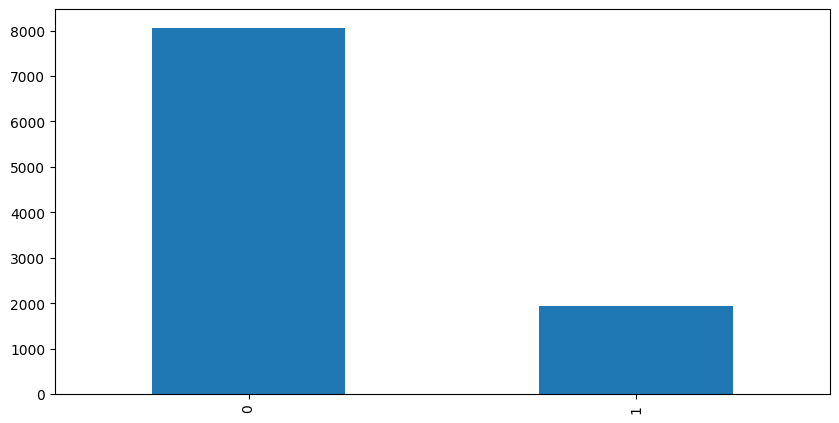

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['Risk'].value_counts().plot(kind='bar', ax=ax1)

skin_df.groupby(['Risk','cell_type']).size()


In [8]:
#for manual downsampling of M Nevi, instead trying random over and undersampling and class weights

# # Because too many Melanocytic Nevi, randomly 2410 samples
# #balances data a bit
# df_random = skin_df[skin_df['cell_type'] == 'Melanocytic nevi'].sample(n=2410, random_state=1)
# skin_df = skin_df.drop(skin_df[skin_df['cell_type']== 'Melanocytic nevi'].index)
# skin_df = skin_df.append(df_random)

# #make new csv for downsampled dataframe
# skin_df.to_csv('data/metadata_downsample.csv')
#put the images of the new dataset into a different folder

# try:
#     os.mkdir(f'{os.getcwd()}/data/images/images_downsample')
# except:
#     pass

# df_read = pd.read_csv('data/metadata.csv')

# for i in range(len(df_read)):
#   copy(f"data/images/resize_HAM10000/{df_read['image_id'].values[i]}.jpg", f"data/images/images_downsample/{df_read['image_id'].values[i]}.jpg")
#imgs_downsample_list = os.listdir('data/images/images_downsample')

In [9]:
def define_dataset(csv, unique=False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['Risk'].values # Define the Labels

  if unique: # Counting unique values
      df['cell_type'].value_counts() # Returning amout of unique value
  
  return img, target
     

In [10]:
#'data/metadata_downsample.csv'
# Defining dataset into labels and features
skin_df.to_csv('data/new_metadata.csv')
img, target = define_dataset('data/new_metadata.csv')

In [18]:
def split_data(x, y, test_size=0.2, validation_size=0.15, balancing=False):
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, y_train):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    undersample = RandomUnderSampler(sampling_strategy=0.7)
    oversample= RandomOverSampler(sampling_strategy=0.5)
    x_train,y_train = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    #x_train, y_train  = undersample.fit_resample(x_train.values.reshape(-1,1),y_train)
    
    #x_val, y_val  = undersample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, y_train
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_size)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, y_train = balancing_dataset(x_train, y_train)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [19]:
# Splitting into train, valid and test with balancing all of the data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(img, target, balancing=True, test_size=0.2, validation_size=0.15)

y_train_series = pd.Series(y_train)
y_train_series.value_counts()


#y_train_series.to_csv('data/modelling/my_saved_models/RandomUnderSamplerXception_dropout0.15_epochs12_{accuracy:.2f}acc_YTRAIN.csv')

Train:  8227
Val:  1202
Test:  2003


0    5485
1    2742
dtype: int64

In [20]:
#convert the images to vectors, default 64 by 64.  Then rescale by 255
def to_tensor(image_paths, oversample=True, size=64):
  imgs = []
  for i in tqdm(image_paths):
    if oversample: # If datasets is balanced
      img = load_img(f"data/images/resize_HAM10000/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
    else:
      img = load_img(f"data/images/resize_HAM10000/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs

In [21]:

# balance the data by oversample to True for x_train, x_valid
x_train = to_tensor(x_train, oversample=True, size=150)
#x_val = to_tensor(x_val, size=150)
# x_test = to_tensor(x_test)

# Unbalanced datasets
#x_train = to_tensor(x_train, oversample=False)
x_val = to_tensor(x_val, oversample=False, size=150)
x_test = to_tensor(x_test, oversample=False, size=150) # Since this is only the test dataset, no need to balanced this

100%|██████████| 2003/2003 [00:02<00:00, 697.01it/s]


In [22]:
# Prediction the test datasets portion
def predictions(model, x_test, y_test, accuracy=True, axis=1):
  
  predictions = model.predict(x_test) # Predict the test datasets
  pred = np.argmax(predictions, axis=axis) # Showing the greatest value from predictions (range: 0-1, biggest is 1)
  
  # Printing the accuracy, with comparing predictions with labels of test datasets portion
  if accuracy: 
    print("\nAccuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))
  
  return pred, x_test, y_test

In [23]:
# Defining the models

def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, callbacks=None, generator=True,
                    checkpoint=None):
  
  dataset = (x_train, y_train, x_val, y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
    
  model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(2, activation='softmax', kernel_regularizer=l2(regularizer)),
  ])

  model.compile(optimizer=Adam(lr=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()
  
  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
  
  _ = predictions(model, x_test, y_test)

  return history, model

In [24]:
epochs = 12
dropout = 0.15
batch_size = 32
learning_rate= 1e-4
fine_tuning = True

base_model= 'Xception'

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoints = ModelCheckpoint('data/modelling/' + 'model_weights/' + 'RandomOverSampler' + base_model + '_dropout' +  str(dropout) + '_epochs' + str(epochs) + "_{accuracy:.2f}acc.h5", verbose=1)


history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                 fine_tuning=fine_tuning, epochs=epochs, base_model=base_model, 
                                 dropout=dropout, regularizer=0.1, batch_size=batch_size,
                                 callbacks=callbacks, summary=True, checkpoint=checkpoints)

# Xception is the best so far
# After 3-5x training the model:
# Dropout 0.15 accuracy: 97% Dropout 0.2 accuracy: 96% Dropout 0.3 accuracy: 91%




2023-02-01 19:16:01.370992: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-01 19:16:01.376668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-01 19:16:01.426713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:16:01.427010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.80GiB deviceMemoryBandwidth: 119.24GiB/s
2023-02-01 19:16:01.427053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 19:16:01.440891: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3

2023-02-01 19:16:03.424161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-01 19:16:03.450513: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/12
258/258 [==============================] - 991s 4s/step - loss: 0.8041 - accuracy: 0.7390 - val_loss: 0.6029 - val_accuracy: 0.8677

Epoch 00001: saving model to data/modelling/model_weights/RandomOverSamplerXception_dropout0.15_epochs12_0.78acc.h5
Epoch 2/12
258/258 [==============================] - 975s 4s/step - loss: 0.6136 - accuracy: 0.8414 - val_loss: 0.5316 - val_accuracy: 0.8844

Epoch 00002: saving model to data/modelling/model_weights/RandomOverSamplerXception_dropout0.15_epochs12_0.85acc.h5
Epoch 3/12
258/258 [==============================] - 951s 4s/step - loss: 0.5148 - accuracy: 0.8822 - val_loss: 0.4896 - val_accuracy: 0.8952

Epoch 00003: saving model to data/modelling/model_weights/RandomOverSamplerXception_dropout0.15_epochs12_0.88acc.h5
Epoch 4/12
258/258 [==============================] - 875s 3s/step - loss: 0.4385 - accuracy: 0.9013 - val_loss: 0.4670 - val_accuracy: 0.8894

Epoch 00004: saving model to data/modelling/model_weights/RandomOverSamplerX

2023-02-01 22:17:14.928744: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 540810000 exceeds 10% of free system memory.



Accuracy: 90.06%


In [25]:
saved_model_dir = 'data/modelling/my_saved_models/'

model.save(saved_model_dir + 'RandomOverSampler' + base_model + '_dropout' +  str(dropout) + '_epochs' + str(epochs) + "_{accuracy:.2f}acc")

2023-02-01 22:45:43.025146: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/modelling/my_saved_models/RandomOverSamplerXception_dropout0.15_epochs12_{accuracy:.2f}acc/assets


In [3]:
dropout= 0.15

dataset = (x_train, y_train, x_val, y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  train_dataset = generators.flow(trainX, trainY, batch_size=BATCH_SIZE)
  valid_dataset = generators.flow(valX, valY, batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                  zoom_range=zoom_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  shear_range=shear_range,
                                  horizontal_flip=horizontal_flip,
                                  fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX, valY, batch_size=BATCH_SIZE)
dataset = (x_train, y_train, x_val, y_val)
pool_size = 2
regularizer = 0.01
BATCH_SIZE = 32
INPUT_SHAPE = dataset[0][0].shape
weights = 'imagenet'
include_top=False
base_model = Xception(weights=weights, 
include_top=include_top, 
input_tensor=Input(shape=INPUT_SHAPE))

epochs = 12
dropout = 0.15
batch_size = 32
learning_rate= 1e-4
fine_tuning = True


model = Sequential([base_model, 
                      AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                      Flatten(), 
                      Dense(64, activation='relu'),
                      Dropout(dropout), 
                      Dense(16, activation='relu'),
                      Dense(2, activation='softmax', kernel_regularizer=l2(regularizer)),
  ])
  
model.compile(optimizer=Adam(learning_rate=1e-4), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=['accuracy'])
                
history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose,
                      callbacks=[callbacks, checkpoint])
#model.load_weights('data/modelling/model_weights/HAM10000_Xception_dropout015_0.98acc.h5')

NameError: name 'x_train' is not defined

In [2]:
# Scoring saved models/checkpoint models
model = load_model('data/modelling/my_saved_models/RandomOverSamplerXception_dropout0.15_epochs12_{accuracy:.2f}acc')

2023-02-02 10:21:54.784187: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-02 10:21:54.787780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-02 10:21:54.816912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 10:21:54.817077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.80GiB deviceMemoryBandwidth: 119.24GiB/s
2023-02-02 10:21:54.817126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-02 10:21:54.819594: I tensorflow/stream_executor/platform/def

In [3]:


def scoring(model, x_test, y_test, verbose=0, returning='confusion_matrix'):
  
  score = model.evaluate(x_test, y_test, verbose=verbose)
  predicting = model.predict(x_test)
  pred = np.argmax(predicting, axis=1)
  conf = confusion_matrix(y_test, pred)  
  
  if returning in ['score', 'scoring']:
    return score
  
  if returning in ['predicting', 'pred', 'predict']:
    return pred

  if returning in ['conf', 'confusion_matrix', 'confussion', 
                   'confusion', 'conf_mat', 'confusion_mat']:
    return conf

In [4]:
score = scoring(model, x_test, y_test, returning='score')
confusion_mat = scoring(model, x_test, y_test, returning='confusion_mat')

NameError: name 'x_test' is not defined

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 98.08%


In [ ]:
def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
  fig, ax = plt.subplots(figsize=(10,10))
  
  sns.heatmap(confusion_mat, annot=True, fmt='.2f',
            xticklabels=[f"{c}" for c in class_names], 
            yticklabels=[f"{c}" for c in class_names],
            cmap=cmap)
  
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

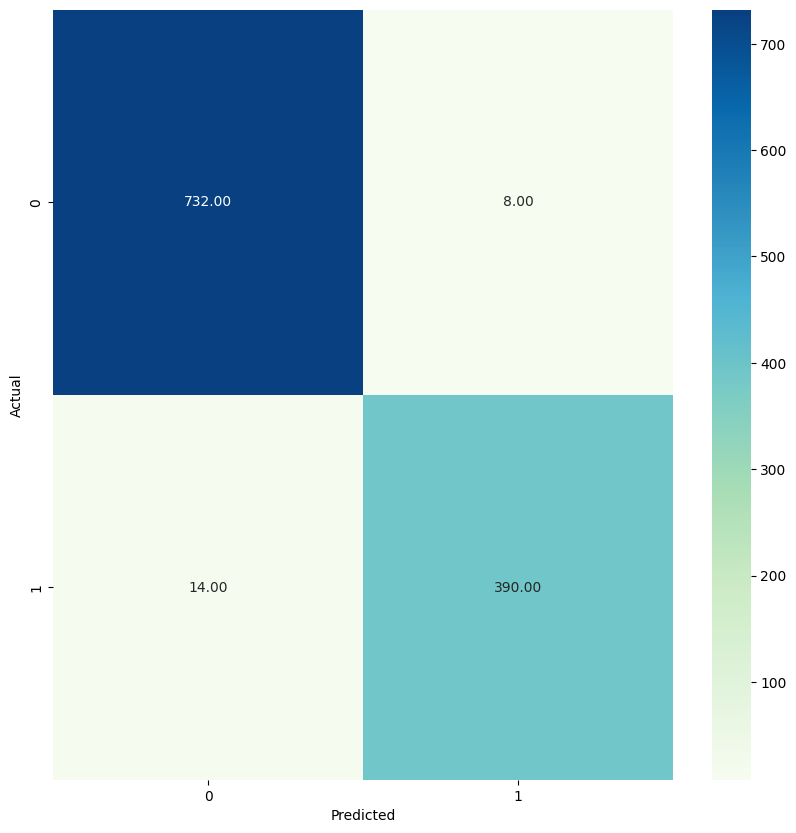

In [ ]:
class_names = [0,1]
plot_confusionmat(confusion_mat, class_names)

#confusionmatrix ([733 11][15 387])

In [65]:
model.save('data/modelling/my_saved_models/multimodel_binarytarget_31012023')

INFO:tensorflow:Assets written to: data/my_saved_models/multimodel_binarytarget_31012023/assets


In [28]:
model = load_model('SAM_multimodel_binarytarget_31012023')

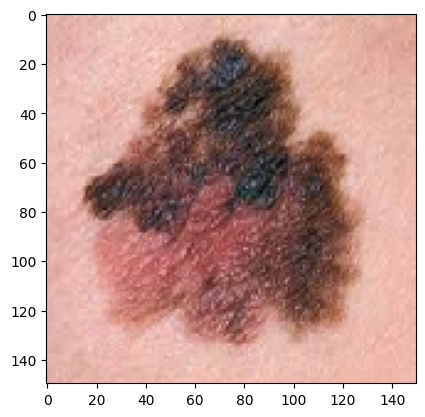


Predicting: 92.32% of 1
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


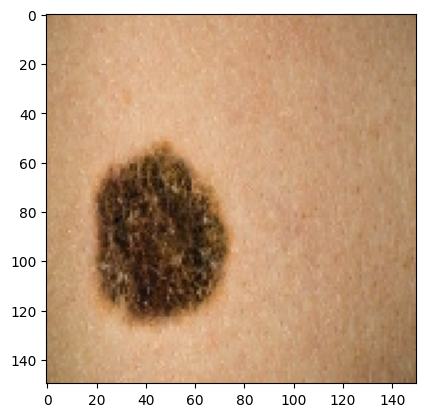


Predicting: 92.11% of 1
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


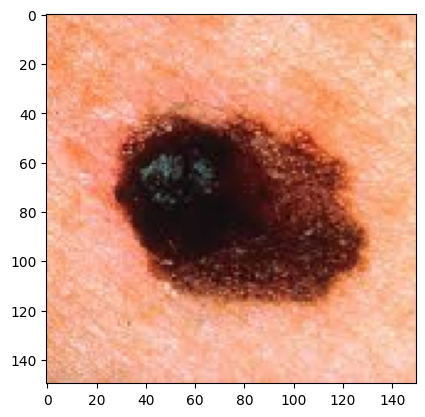


Predicting: 86.86% of 1
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


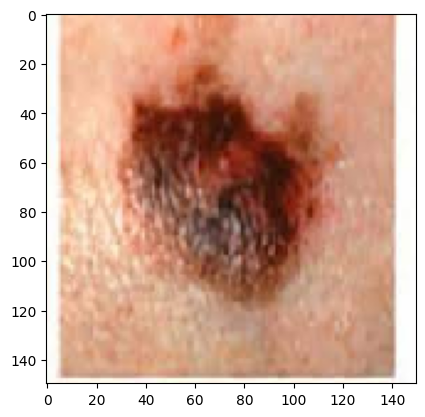


Predicting: 99.99% of 1
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


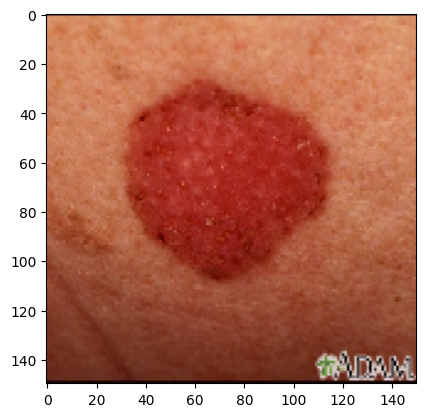


Predicting: 99.08% of 0
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


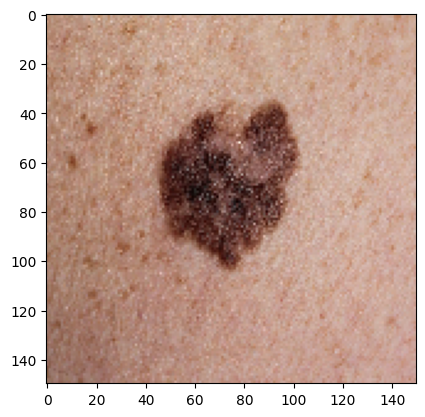


Predicting: 100.00% of 0
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


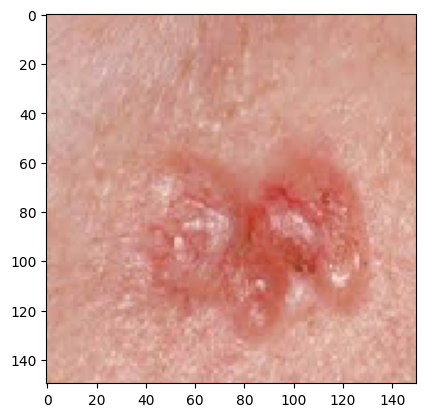


Predicting: 96.29% of 1
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


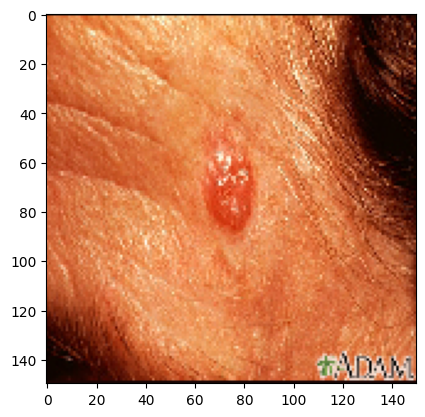


Predicting: 99.98% of 0
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


In [34]:
# test some picture here

# this is for general testing
def image_analyzer(image, images_path):

  img_array = []

  path = images_path + image
  
  plt.imshow(load_img(path, target_size=(150, 150)))
  plt.show()
  
  img = load_img(path, target_size=(150, 150))
  img = img_to_array(img)
  img = img.astype(np.float32) / 255
  img_array.append(img)

  img_array = np.stack(img_array, axis=0)

  predictions = model.predict(img_array)
  pred = np.argmax(predictions, axis=1)
    
  print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names[pred[0]]}")
  if class_names[pred[0]] != 1:
    print("Kind of Cancer: Benign")
    print("Benign means it is not a dangerous cancer or not a cancer")
  else:
    print("Kind of Cancer: Malignant")
    print("Malignant means dangerous and deadliest cancer")
  
  return

images_path = 'data/internet_images/'
for image in os.listdir(images_path):
  image_analyzer(image, images_path)

In [ ]:
# test some picture here
# Model 3

imgs = []

path = 'download.png'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")